# Visualizando Isocronas em R

esse tutorial apresenta uma metodologia para produzir e visualizar isocronas em R
o codigo foi baseado nesse exemplo: https://rpubs.com/maiae/drivetime

## Instalando os Pacotes Necessarios

In [84]:
devtools::install_github("rCarto/osrm") #https://github.com/rCarto/osrm
install.packages("leaflet") #https://rstudio.github.io/leaflet/
install.packages("plotly")
install.packages("GISTools")

from URL https://api.github.com/repos/rCarto/osrm/zipball/master
Installing osrm
'/usr/lib/R/bin/R' --no-site-file --no-environ --no-save --no-restore --quiet  \
  CMD INSTALL '/tmp/RtmpdA3MIF/devtools38d947dfb11a/rCarto-osrm-ecde6ab'  \
  --library='/home/jm/R/x86_64-pc-linux-gnu-library/3.4' --install-tests 

Reloading installed osrm
Data: (c) OpenStreetMap contributors, ODbL 1.0 - http://www.openstreetmap.org/copyright
Routing: OSRM - http://project-osrm.org/
Installing package into ‘/home/jm/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/jm/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/jm/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Warning message:
“package ‘GIStools’ is not available (for R version 3.4.0)”Warning message:
“Perhaps you meant ‘GISTools’ ?”

## Carregando os pacotes

In [98]:
library("osrm") # para calcular a isocrona
library("leaflet") # para criar o mapa
library("broom")
library("ggplot2")
library("ggmap")
library(GISTools)
library(rgdal)
library(htmlwidgets)


In [105]:
rm(list = ls()) # remove objects from workspace

## Calculando as Isocronas

usaremos a funcao 
  
```{r}
osmIsochrone(loc = c(lon,lat), breaks = seq(from=tempo_inicial, to=tempo_final, by=intervalo))  
```  


In [108]:
location_name = "inca"
location = c(-43.188470,-22.912590)
#location = c(151.207049, -33.886475)
tempos = seq(from = 0,to = 30, by = 5)

iso <- osrmIsochrone(loc = location, breaks = tempos)
class(iso)

[1] "SpatialPolygonsDataFrame"
attr(,"package")
[1] "sp"

## Plotando as isocronas

### Mapa Estatico

In [122]:
#transforma o SpaialPolygonDataFrame
iso_df <- tidy(iso)
iso$polyID <- sapply(slot(iso, "polygons"), function(x) slot(x, "ID"))
iso_df <- merge(iso_df, iso, by.x = "id", by.y="polyID")
str(iso_df)

Regions defined for each Polygons
Warning message in merge.data.frame(iso_df, iso, by.x = "id", by.y = "polyID"):
“column name ‘id’ is duplicated in the result”

'data.frame':	166 obs. of  12 variables:
 $ id         : chr  "1" "1" "1" "1" ...
 $ long       : num  -43.2 -43.2 -43.2 -43.2 -43.2 ...
 $ lat        : num  -23 -23 -22.9 -22.9 -22.9 ...
 $ order      : int  1 2 3 4 5 6 7 8 9 10 ...
 $ hole       : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ piece      : Factor w/ 8 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ group      : Factor w/ 16 levels "4.1","4.2","4.3",..: 16 16 16 16 16 16 16 16 16 16 ...
 $ id         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ min        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ max        : num  15 15 15 15 15 15 15 15 15 15 ...
 $ center     : num  7.5 7.5 7.5 7.5 7.5 7.5 7.5 7.5 7.5 7.5 ...
 $ drive_times: Factor w/ 4 levels "0 to 15 min",..: 1 1 1 1 1 1 1 1 1 1 ...


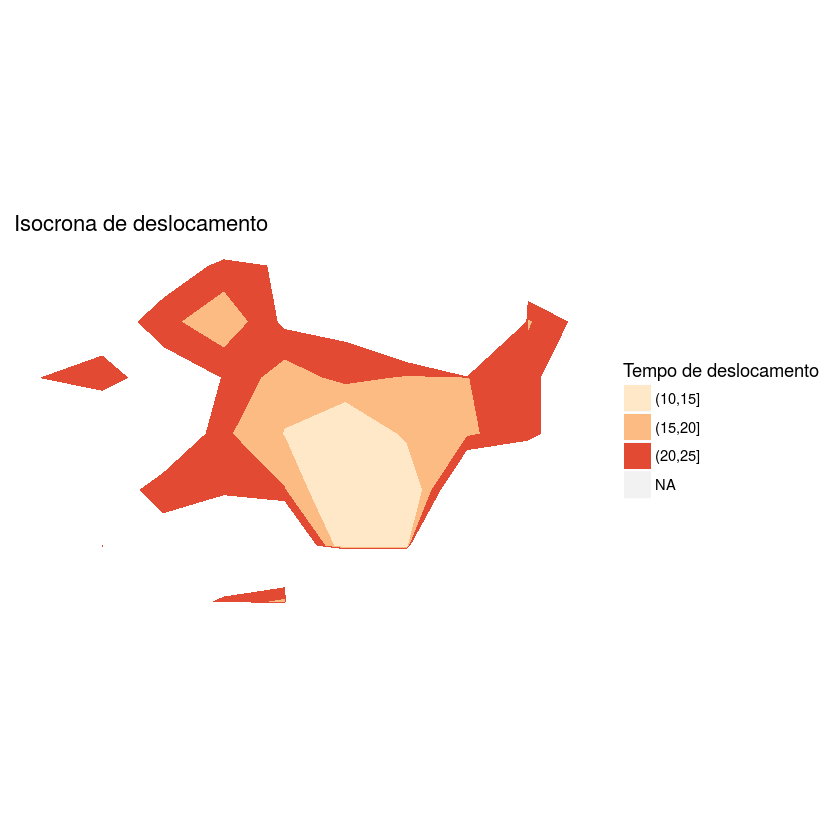

In [125]:
map <- ggplot() +                                               # initialize ggplot object
  geom_polygon(                                          # make a polygon
    data = iso_df,                                    # data frame
    aes(x = long, y = lat, group = group,                # coordinates, and group them by polygons
        fill = cut(min,tempos))) +                # variable to use for filling
  scale_fill_brewer("Tempo de deslocamento", palette = "OrRd") + # fill with brewer colors 
  ggtitle("Isocrona de deslocamento") +    # add title
  theme(line = element_blank(),                          # remove axis lines .. 
        axis.text=element_blank(),                       # .. tickmarks..
        axis.title=element_blank(),                      # .. axis labels..
        panel.background = element_blank()) +            # .. background gridlines
  coord_equal()                                          # both axes the same scale

print(map)

In [82]:
ph_basemap <- get_map(location="Rio de Janeiro, RJ,Brazil", zoom=11, maptype = 'satellite')


Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Rio+de+Janeiro,+RJ,Brazil&zoom=11&size=640x640&scale=2&maptype=satellite&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Rio%20de%20Janeiro,%20RJ,Brazil&sensor=false
Warning message:
“geocode failed with status OVER_QUERY_LIMIT, location = "Rio de Janeiro, RJ,Brazil"”

ERROR: Error in data.frame(ll.lat = ll[1], ll.lon = ll[2], ur.lat = ur[1], ur.lon = ur[2]): arguments imply differing number of rows: 0, 1


## Plotando as isocronas em um map interativo

### criando legendas e uma paleta de cores

In [112]:
# add drive time description to be later used as a legend
iso@data$drive_times <- factor(paste(iso@data$min, "to", iso@data$max, "min"))

# color palette for each area
factpal <- colorFactor(rev(heat.colors(5)), iso@data$drive_times)

### Plota o mapa

In [115]:
# draw map

leaflet() %>% 
                setView(location[1], location[2], zoom = 11) %>%
                addProviderTiles("CartoDB.Positron", group="Greyscale") %>% 
                addMarkers(lng = location[1], lat = location[2], popup = location_name) %>% 
                addPolygons(fill=TRUE, stroke=TRUE, color = "black",
                                        fillColor = ~factpal(iso@data$drive_times),
                                        weight=0.5, fillOpacity=0.2,
                                        data = iso, popup = iso@data$drive_times,
                                        group = "Drive Time") %>% 
                # Legend
                addLegend("bottomright", pal = factpal, values = iso@data$drive_time,   title = "Drive Time")%>%saveWidget(, file=paste (location_name,"_isocrona.html", sep = ""))